###Import libraries

In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [4]:
# Import other libraries
import cv2
#from tensorflow.keras.applications.mobilenet import preprocess_input

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

###Load cleaned dataset

In [5]:
#load dataset
load_data = np.load('/content/drive/MyDrive/AN2DL_HW_1/balanced_dataset_v1.npz', allow_pickle=True)

images = np.array(load_data['data'])#.astype(np.uint8))
y = np.array(load_data['labels'])
labels = {'healthy':0, 'unhealthy':1}

#normalize images
#images = images[:] / 255

In [ ]:
images.shape

(6202, 96, 96, 3)

In [ ]:
y.shape

(6202,)

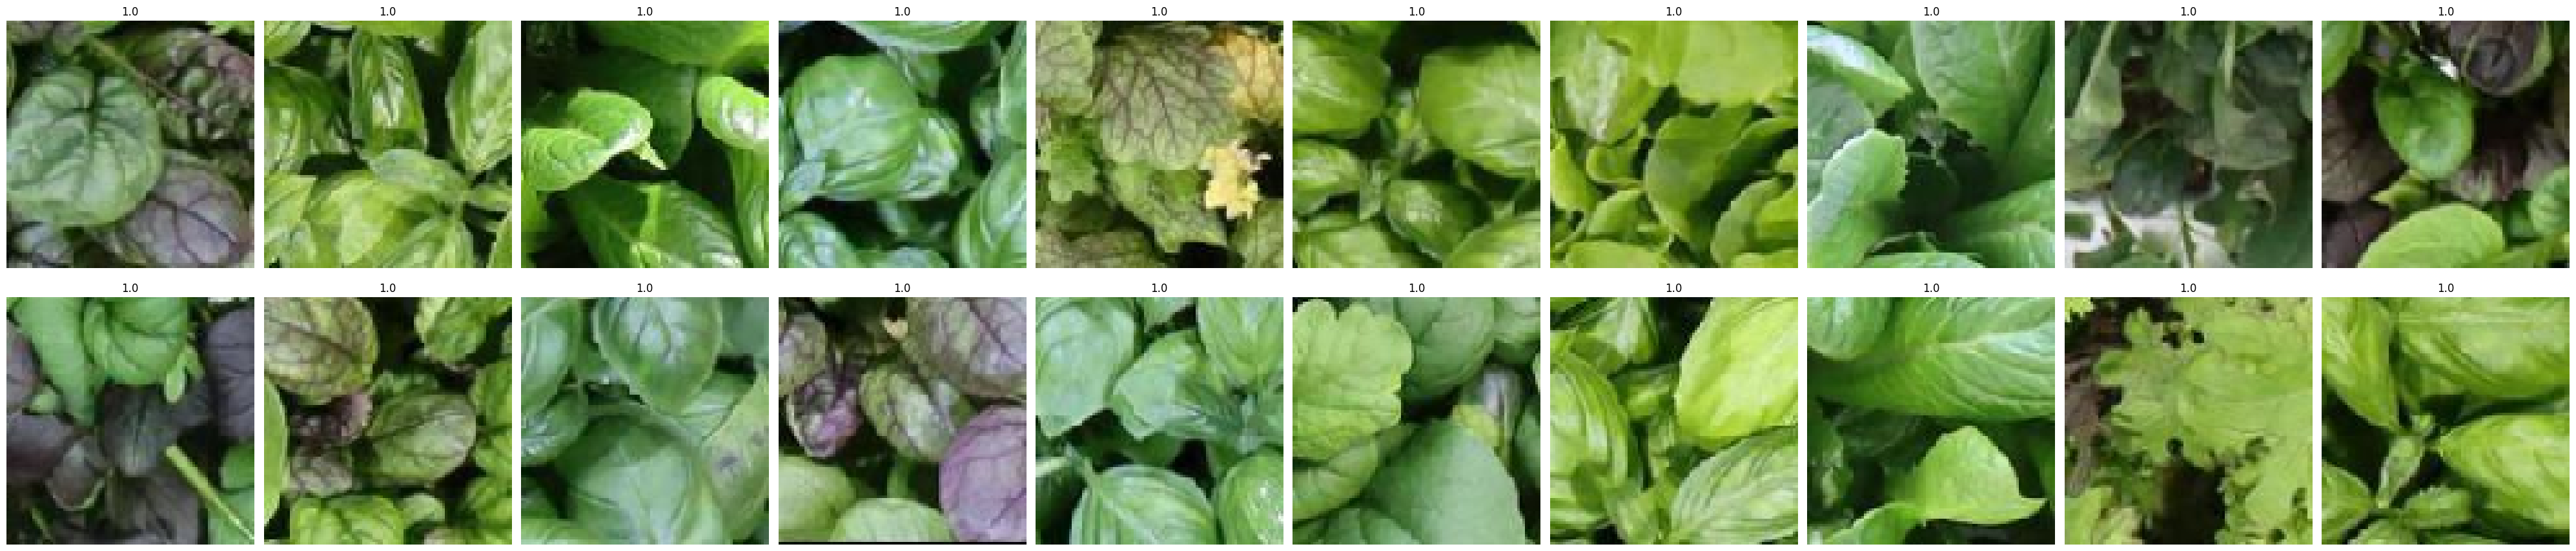

In [ ]:
# Number of images to display
num_img = 20
shift = 1000
# Create subplots for displaying items
fig, axes = plt.subplots(2, num_img//2, figsize=(40, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(images[i+shift], 0, 255))  # Display clipped item images
    ax.set_title(f'{y[i+shift]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


In [6]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y, columns=['status'])['status'].value_counts())

Counting occurrences of target classes:
1.0    3101
0.0    3101
Name: status, dtype: int64


In [ ]:
labels.keys()

dict_keys(['healthy', 'unhealthy'])

In [ ]:
#transform labels in binary values
#for key in labels.keys():
#  y[y==key] = labels[key]

In [7]:
# Convert labels to categorical format using one-hot encoding
y_cat = tfk.utils.to_categorical(y)

# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(images, y_cat, random_state=seed, test_size=0.2, stratify=y_cat)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=seed, test_size=0.2, stratify=y_train)

del images
del y
del y_cat
del load_data

In [8]:
# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)
print("Test Data Shape:", X_test.shape)
print("Test Label Shape:", y_test.shape)

Training Data Shape: (3968, 96, 96, 3)
Training Label Shape: (3968, 2)
Validation Data Shape: (1241, 96, 96, 3)
Validation Label Shape: (1241, 2)
Test Data Shape: (993, 96, 96, 3)
Test Label Shape: (993, 2)


In [9]:
# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])           # Display the categorical label
print('"Default" label:', np.argmax(y_train[0]))   # Display the equivalent numeric label

Categorical label: [1. 0.]
"Default" label: 0


In [10]:
class_weight = {0: 0.62, 1: 1}

## Transfer Learning

In [11]:
from tensorflow.keras.applications.efficientnet import preprocess_input #IMPORT RIGHT PREPROCESSING!!!!


In [ ]:
#CHOSE MODEL
mobile = tfk.applications.EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False,
    weights="imagenet",
    pooling='avg',
)
tfk.utils.plot_model(mobile, show_shapes=True)

In [ ]:
# Use the supernet as feature extractor, i.e. freeze all its weigths
mobile.trainable = False


inputs = tfk.Input(shape=(96, 96, 3))
x = mobile(inputs)
outputs = tfkl.Dense(2, activation='softmax')(x)

# Create a Model connecting input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with Categorical Cross-Entropy loss and Adam optimizer
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy'])

# Display model summary
tl_model.summary()

In [26]:
# Train the model
tl_history = tl_model.fit(
    x = preprocess_input(X_train*255.), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 2000,
    validation_data = (preprocess_input(X_val*255.), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/2000
248/248 [==============================] - 19s 39ms/step - loss: 0.5235 - accuracy: 0.7278 - val_loss: 0.4412 - val_accuracy: 0.7897
Epoch 2/2000
248/248 [==============================] - 5s 20ms/step - loss: 0.4237 - accuracy: 0.8037 - val_loss: 0.4092 - val_accuracy: 0.8139
Epoch 3/2000
248/248 [==============================] - 6s 26ms/step - loss: 0.3926 - accuracy: 0.8241 - val_loss: 0.3887 - val_accuracy: 0.8284
Epoch 4/2000
248/248 [==============================] - 7s 27ms/step - loss: 0.3814 - accuracy: 0.8256 - val_loss: 0.3799 - val_accuracy: 0.8276
Epoch 5/2000
248/248 [==============================] - 6s 25ms/step - loss: 0.3636 - accuracy: 0.8317 - val_loss: 0.3824 - val_accuracy: 0.8251
Epoch 6/2000
248/248 [==============================] - 7s 26ms/step - loss: 0.3563 - accuracy: 0.8392 - val_loss: 0.4311 - val_accuracy: 0.7897
Epoch 7/2000
248/248 [==============================] - 5s 19ms/step - loss: 0.3470 - accuracy: 0.8417 - val_loss: 0.3705 - val_a

In [27]:
name = '/content/drive/MyDrive/AN2DL_HW_1/Transfer_learning_models/EfficientNetB2'     #CHOSE NAME!!!!


save = True

if save is True:
  tl_model.save(name)
  del(tl_model)